# Predicting the Success of Bank Telemarketing 

Import libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
import xgboost as xg
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss, plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import confusion_matrix as cm
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')



# Abstract and Data Origin 

The dataset of this project pertains to direct telemarketing campaigns of a Portuguese banking institution. Information about the bank's client, as well as social and economic attributes, are all captured within this dataset through 41,118 client touchpoints across different 20 features. 
The objective and goal at hand is to predict and classify whether a client that has been reached out to will subscribe to a bank's term deposit or not. The telemarketing campaigns were based on phone calls made to clients. Oftentimes, more than one point of contact to the same client was required in order to assess if the product (bank term deposit) was subscribed by the client. 

Further details of the origins of the data can be found in the link:
https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

Citation: [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014



# Business Understanding and Overview of Project  

Acquiring new prospects in order to accumulate additional assets under management is one of the key important avenues of growth for a financial institution. As prospects and clients earn a bank's trust, they will become more inclined to deposit their savings with the bank. Once a bank earns the trust of its clients, assets become revenue streams as clients begin to venture into opening additional accounts, on top of their savings account, such as brokerage accounts, retirement accounts, line of credits, mortgages, as well as private equity and venture capital accounts. In a world where interest rates are very low, it becomes even more imperative to capture the trust of prospects and clients, as traditional banks and neo-banks compete for assets.

In today's financial services industry, client data has become another key differentiator for an institution's abiliity to surivive in this hyper-competitve environment. One key way for financial institutions to provide a better overall customer experience for its prospects and clients is to leverage the power of machine learning, specifically when it pertains to prospecting clients and soliciting new financial products while also minimzing the intrusive nature of soliciting as well as the time and resources dedicated for telemarketing campaigns. 

The core business prolblem at hand relates to building a classfier to predict whether a client will subscribe to a term deposit, with the aim of identifying key features that may drive campaign efficiency. On top of building a predictive classifier, we would also want to determine the key influential factors that drive a prospect or client's decision to subscribe to a term deposit. By building a predictive model and identifying key factors, banks can improve their sales pipeline and increase effciency by reducing time, resources, and costs when reaching out to prospects and clients, while maintaining a non-invasive relationship with all clients.

# Functions 

For organizational purposes, this section will be utilized to store all functions used in this project. 

In [2]:
def bargraph_target(feature, dataset):
    
    '''
    This function serves to plot out each categorical column feature against the 'y' target variable to visuzlize the relationship 
    between each feature and whether customers subscribed to the term deposit (y or n).
    This function takes in the dataframe and illustrates each category against the target variable. '''
        
    plt.figure(figsize=(15,5))
    Y = bank_df[feature]
    total = len(Y)*1
    #plot against target 'y'
    ax = sns.countplot(x = feature, data = dataset, hue = "y")
    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
    
    ax.yaxis.set_ticks(np.linspace(0, total, 11))
    ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
    plt.show()


In [3]:
def distplot_continuous(feature):
    '''
    This function serves to plot out each continuous column feature to visualize the distribution of continuous variables.
    '''
    %matplotlib inline
    plt.figure(figsize=(10,8))
    sns.distplot(feature)
    return plt.show();

In [4]:
def plot_feature_importances(model):
    '''
    This function serves to plot out all feature importances across all models deployed.'''
    
    n_features = X_train_scaled.shape[1]
    plt.figure(figsize=(8,20))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_scaled.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

# Exploratory Data Analysis 

We will be going over the dataset for this project and reviewing the data for further preprocessing purposes down the line. 

As described from the abstract of the dataset, we notice that the first 20 columns are attributes related to clients, with the last remaining column as the target variable 'y'. The target variable denotes whether clients subscribed to ther term deposit or not, indicated as 'yes' or 'no'. 

In [5]:
#load and read the csv file containing the dataset
bank_df = pd.read_csv('Data/bank-additional-full.csv', sep= ";" )

In [6]:
#review first 5 entries of bank telemarketing dataset.  
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
#review shape of dataframe
bank_df.shape

(41188, 21)

Here, we notice that some of the columns are object types while other columns contain integer and floats. It may be worthwhile to look into all features to identify which features are categorical and which features are continuous. As we know, machine learning algorithms cannot take object types, thus we will eventually have to preprocess the categorical columns later on for modeling purposes.  

In [8]:
'''review dtype of all 21 columns across 41,118 entries...
...based on the dataframe and dtype, we recognize that object columns such as 'job', 'marital', and 'education' are categorical, while other columns 
such as 'age', duration', are continuous.'''

bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

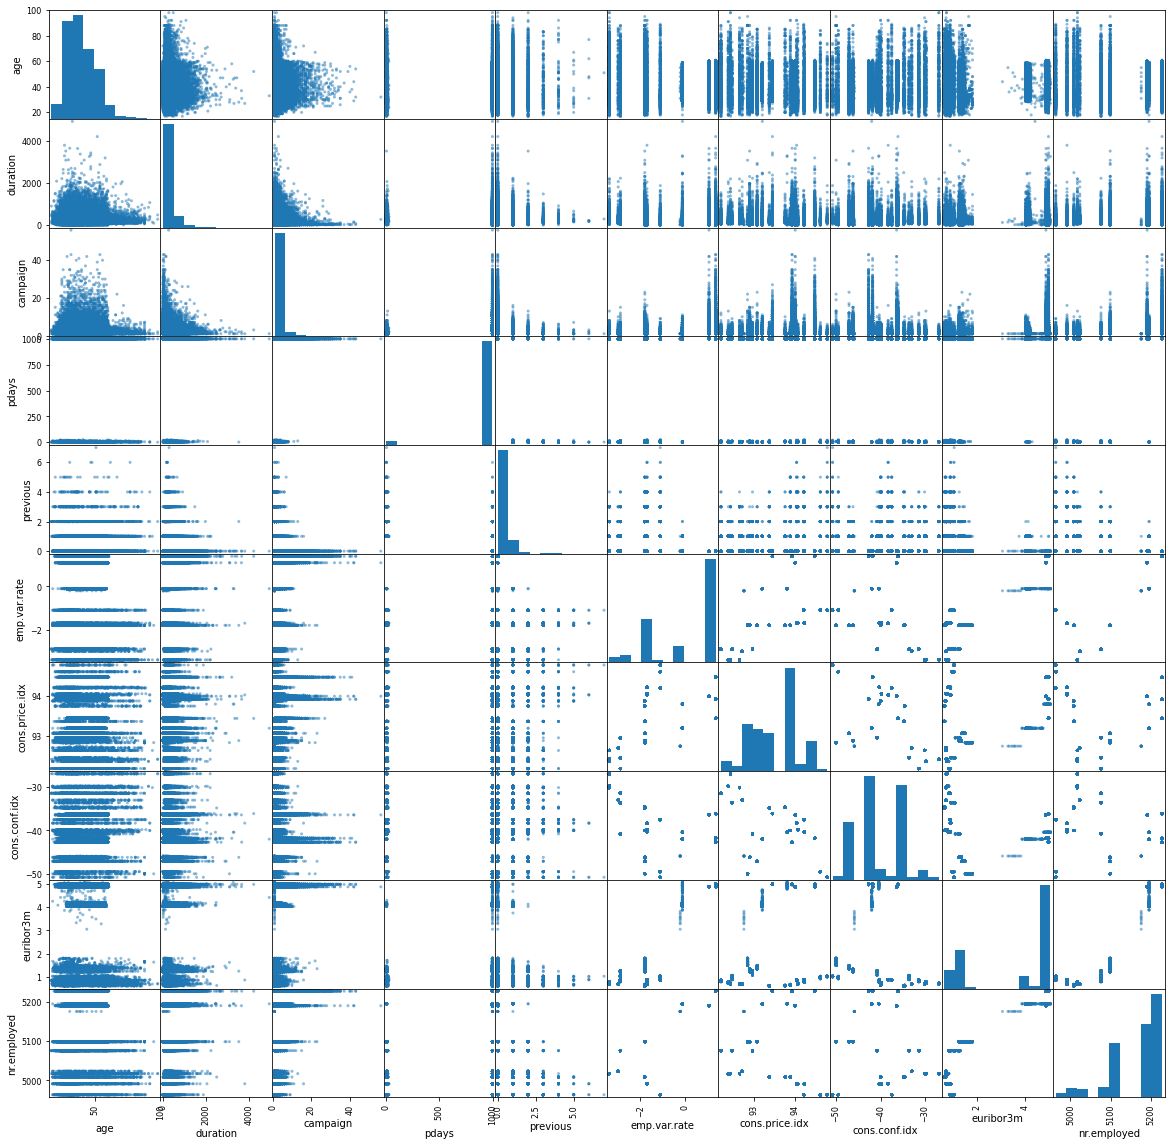

In [9]:
#visualize a scatter matrix for all columns to identify continuous and categorical features for further processing
pd.plotting.scatter_matrix(bank_df, figsize = [20, 20]);
plt.show()

In [10]:
#create a variable that holds all continous variables for later processing based on dtypes as int64 and float64 
continuous = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

#create a variable that holds all categorical variables for later processing based on dtypes as object, excluding our target 'y' variable
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

From the summary statistics below, we notice that for the feature 'pdays', although a continuous variable, contains '999' for majority of values. As such, we will convert pdays from continuous to categorical during the preprocessing phase.  

In [11]:
#summary statistics of all features
bank_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


This dataset contains no null values and therefore no columns will need to be dropped. 

In [12]:
#check for any null values. 
bank_df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

After checking for null values, we will then check for any duplicate values

In [13]:
#check for any duplicates 
bank_df[bank_df.duplicated(keep = "last")]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20072,55,services,married,high.school,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20531,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25183,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28476,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32505,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


In [14]:
#identify new df with duplicated values
bank_df_duplicated = bank_df[bank_df.duplicated(keep = "last")]
bank_df_duplicated

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20072,55,services,married,high.school,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20531,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25183,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28476,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32505,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


In [15]:
#check on shape of duplicated dataframe
bank_df_duplicated.shape

(12, 21)

In [16]:
#drop duplicates
bank_df = bank_df.drop_duplicates()

In [17]:
#check on dataframe after duplicates have been dropped. We see that we now decreased our rows by the 12 duplicated entries from 41,188 to 41,176
bank_df.shape

(41176, 21)

Check on our target variable, 'y', for any class imbalance. In this instance, 'y' denotes that customers subscribed and opened the bank's term deposit. Here we've identified that this data has a class imbalance in which only 11.3% of customers subscribed to the bank's term deposit, while the remaining 88.7% of customers did not. It seems like we will also eventually have to convert our target "y" column from 'yes' and 'no' to '1' and '0'.  

In [18]:
#check for class imbalance on target Y variable. 
bank_df['y'].value_counts(normalize=True)

no     0.887337
yes    0.112663
Name: y, dtype: float64

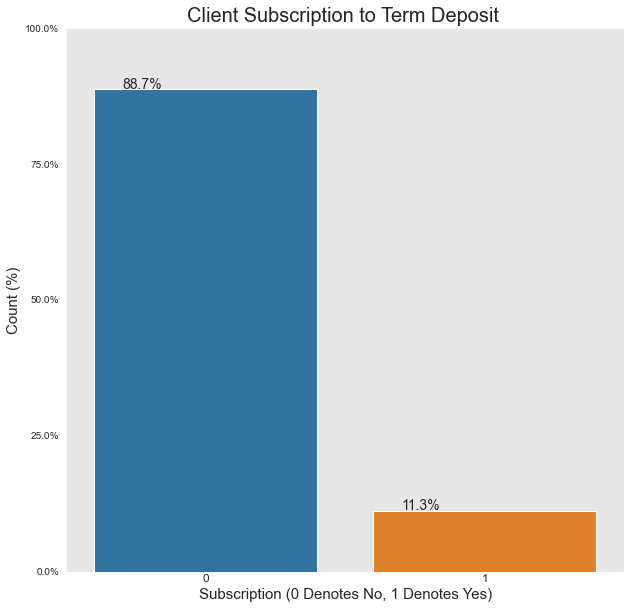

In [151]:
plt.figure(figsize=(10,10))
Y = bank_df["y"]
total = len(Y)*1.
ax=sns.countplot(x="y", data=bank_df)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5), fontsize = 14)


ax.yaxis.set_ticks(np.linspace(1, total, 5))
 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
ax.set_xticklabels(ax.get_xticklabels(), rotation=None, ha="center", va = 'center', fontsize = 12)

plt.title('Client Subscription to Term Deposit ', fontsize = 20)
plt.ylabel('Count (%)', fontsize = 15)
plt.xlabel('Subscription (0 Denotes No, 1 Denotes Yes)', fontsize = 15)
plt.grid(False)


plt.show()


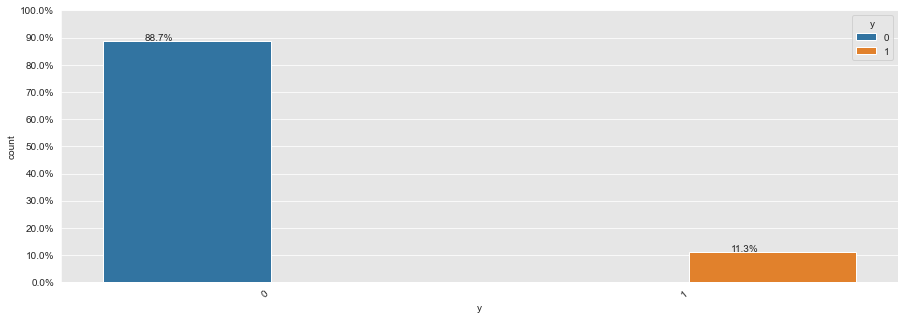

In [152]:
#visually we can observe the class imbalance exhibited in our target variable
bargraph_target('y', bank_df)


# Target Variable Preprocessing

From the exploratory analysis above, we've identified that we will need to replace 'no' and 'yes' with '0' and '1' for our target variable column, 'y'.

In [20]:
bank_df['y'].value_counts()

no     36537
yes     4639
Name: y, dtype: int64

In [21]:
bank_df['y'].value_counts(normalize=True)

no     0.887337
yes    0.112663
Name: y, dtype: float64

In [22]:
#replace no with 0, yes with 1
bank_df['y'].replace({"no": 0, "yes": 1}, inplace = True)

We've replaced "no" with 0 and "yes" with 1 to make the target variable "y" numerical. 

# Variable Analysis - Categorical

We've recognized that our model contains categorical and continuous features. Here, we plot all categorical variables based on each category. It looks like 'housing', 'loan', and 'poutcome' all contain values labeled as 'unknown' that may require further preprocessing. 

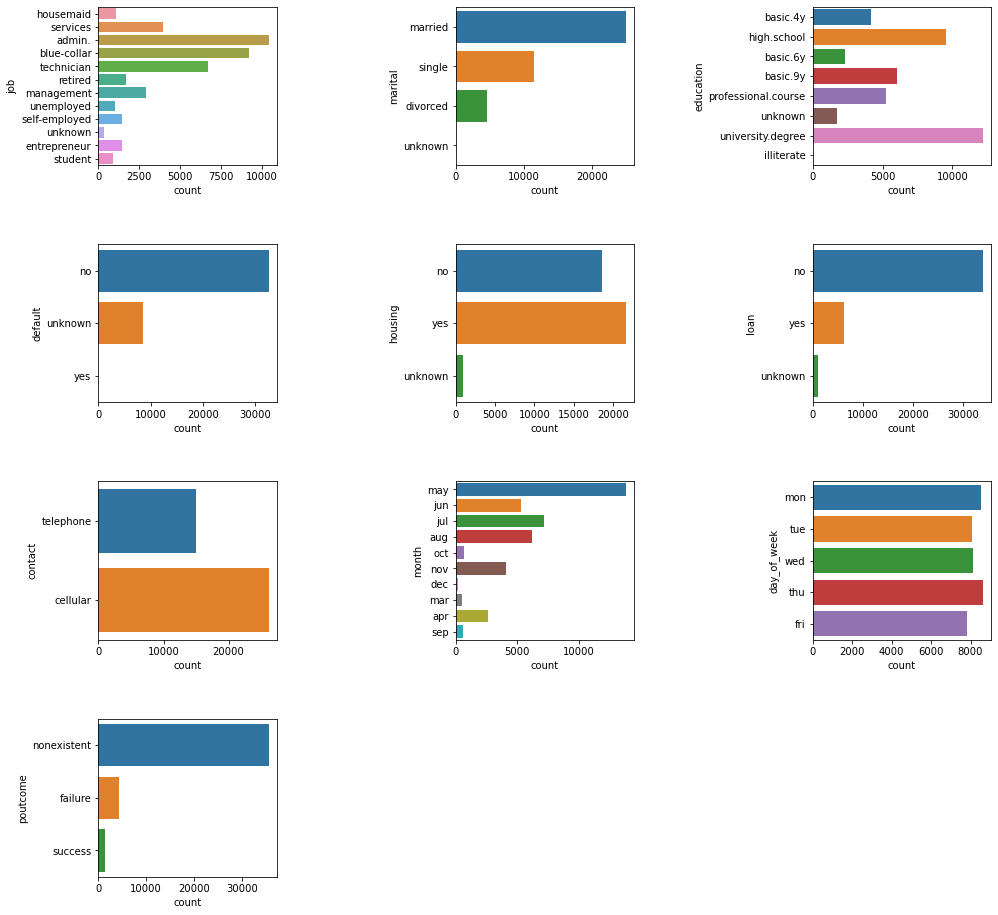

In [23]:
#visualize all categorical variables

fig, axes = plt.subplots(4, 3, figsize = (16,16))
plt.subplots_adjust(wspace = 1, hspace = 0.5)

for i, ax in enumerate(axes.ravel()):
    if i > 9:
        ax.set_visible(False)
        continue
    sns.countplot(y = categorical[i], data = bank_df, orient = "h", ax = ax)
    
plt.show();

We then called upon our function to visualize the relationship between each categorical feature and target feature to identify whether certain attributes within a category contain higher subscription frequency for the term deposit. 

Graphically, it looks like customers with admin jobs have the highest rate of subscribing across all occupations, followed by technicians and blue-collar workers. Although admins, blue-collar workers, and technicians have the top three highest subscription rates, they also happen to be the top 3 jobs held by clients, thus they also happen to be the top three highest groups of clients who did not subscribe to a term deposit. 

Interestingly enough, we also notice that housemaids, self-employed, and entrepreneurs, have the lowest subscription rates to term deposit accounts, perhaps due to the lack of savings in their respective profession.  

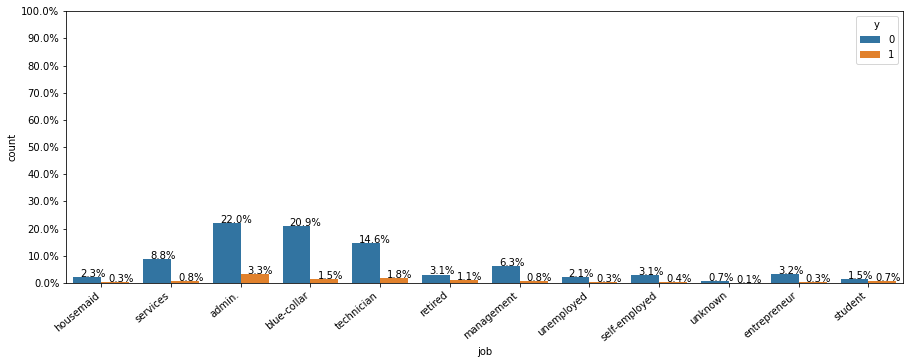

In [24]:
bargraph_target("job", bank_df)

In [25]:
#admin, blue-collar, and technicians are the 3 most common job types 
print(bank_df['job'].value_counts())

admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64


Married couples make a a large percentage of customers, but are also the most subscribed customers, perhaps due to the need to save for future goals.  

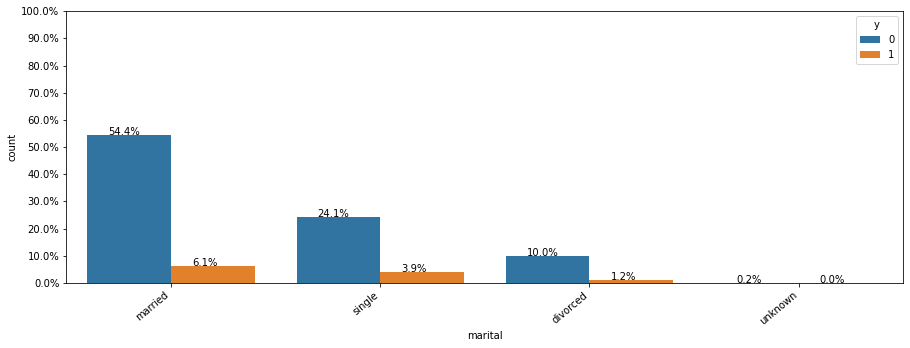

In [26]:
bargraph_target("marital", bank_df)

Those with university degrees were the most highly subscribed subsector of customers to the bank's campaign, but were also the most predominant subcategory as well.  

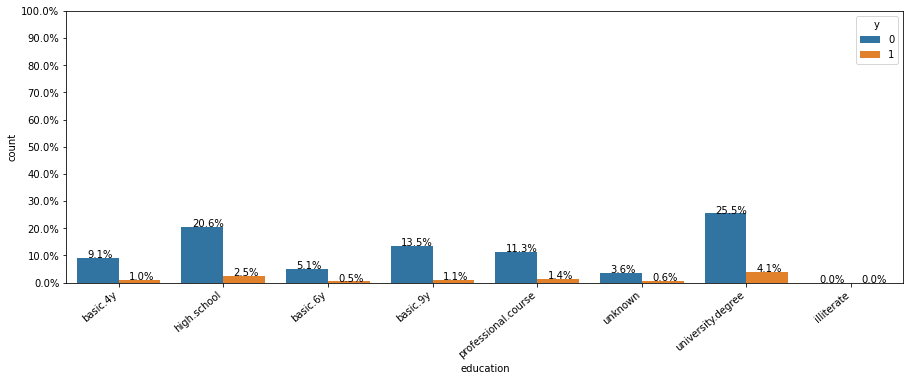

In [27]:
bargraph_target("education", bank_df)

In [28]:
print(bank_df['education'].value_counts())

university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: education, dtype: int64


Customers without any credit defaults were much highly likely to subscribe to the bank's campaign, perhaps due to having extra sidelined cash.  

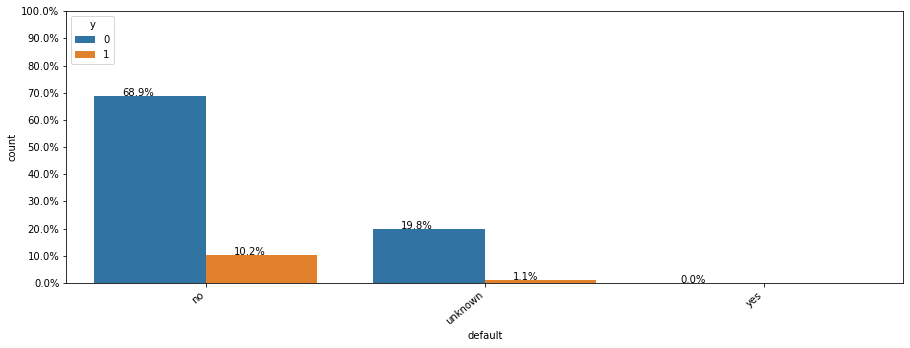

In [29]:
bargraph_target("default", bank_df)

Those with a housing loan with the bank were likely to also have a term deposit. 

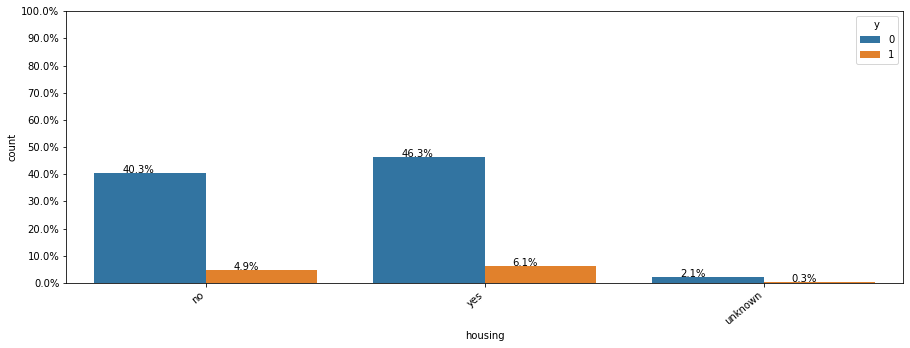

In [30]:
bargraph_target("housing", bank_df)

Customers who don't have a personal loan with the bank were more likely to subscribe to the term deposit, perhaps due to the flexibility of not having any interest payments and therefore having extra cash to generate interest via the term deposit.  

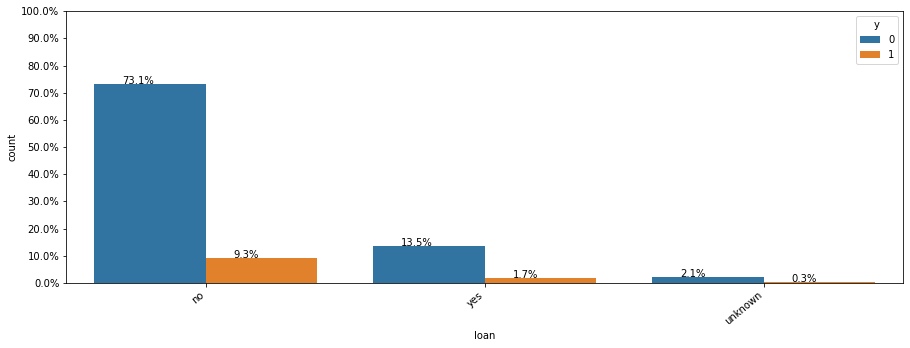

In [31]:
bargraph_target("loan", bank_df)

Customers who were contacted via cell phone over telephone landline were more likely to subscribe to the term deposit. 

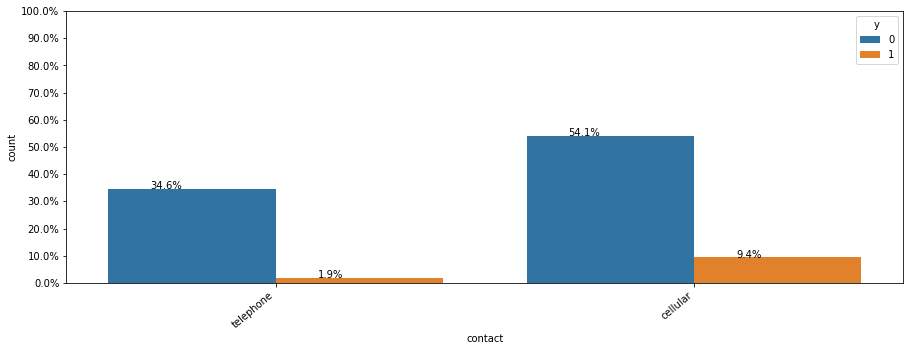

In [32]:
bargraph_target("contact", bank_df)

May, followed by July and August, were the most recent months of contact prior to subscription. 

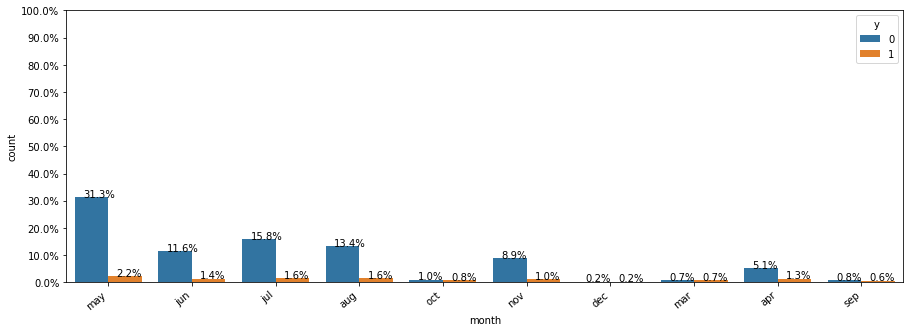

In [33]:
bargraph_target("month", bank_df)

Those who were last contacted on a Thursday had a slightly higher subscription rate, though we cannot conclude whether any particular weekday has a significance over another when it comes to subscribing to term deposits. 

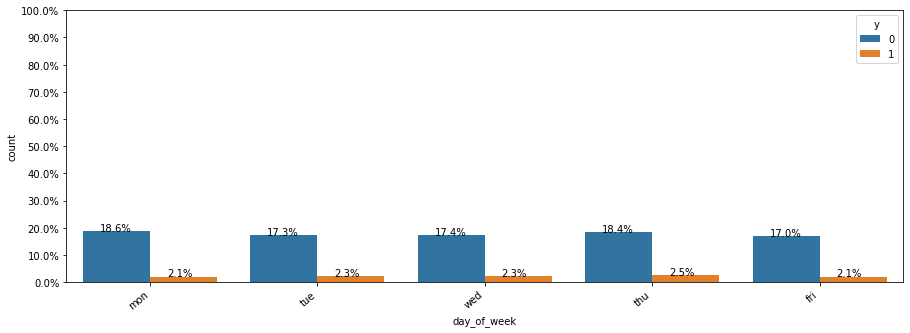

In [34]:
bargraph_target("day_of_week", bank_df)

Most customers were tagged with nonexistent outcomes on the previous marketing campaign. This suggests most customers are contacted by the bank for the very first time. 

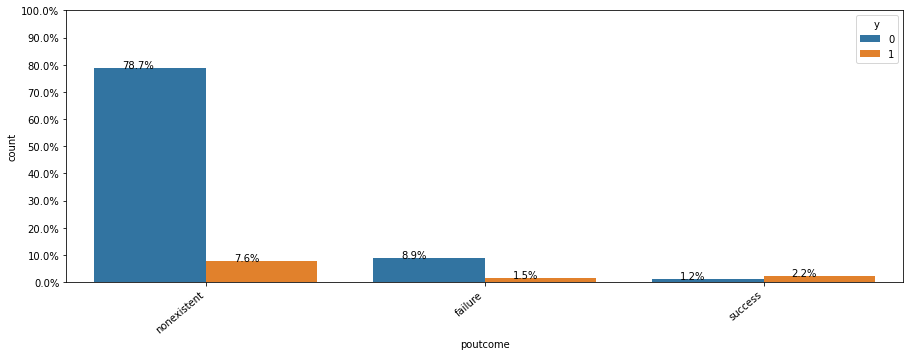

In [35]:
bargraph_target("poutcome", bank_df)

# Variable Analysis - Continuous 

After investigating categorical characteristics of the dataset, we will then look into all continuous features. 

In [36]:
#view all dtypes to identify continuous variables
bank_df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                   int64
dtype: object

In [37]:
#single out floats and integer dtypes
continuous_bank_df = bank_df.select_dtypes(include=['float64', 'int64'])

In [38]:
#create a variable holding all continuous variables 
continuous_variables = bank_df.describe().columns

Through the histogram plots below, we notice that pdays, though numeric, could be replaced as a categorical feature instead. 

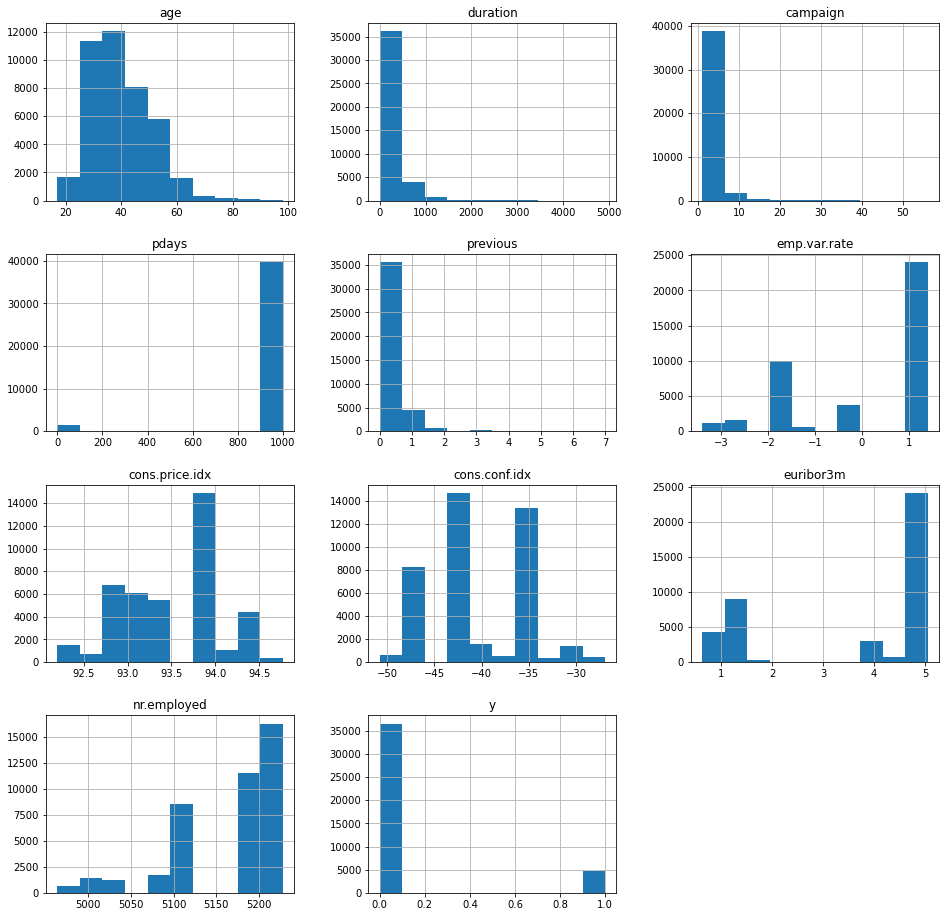

In [39]:
#visualize all continuous variables with histogram
bank_df.hist(column = continuous_variables, figsize = (16,16))
plt.show()

Looked at all continuous variables via boxplots to identify whether there are any trends. We notice that for the duration feature, there contains many outliers.  

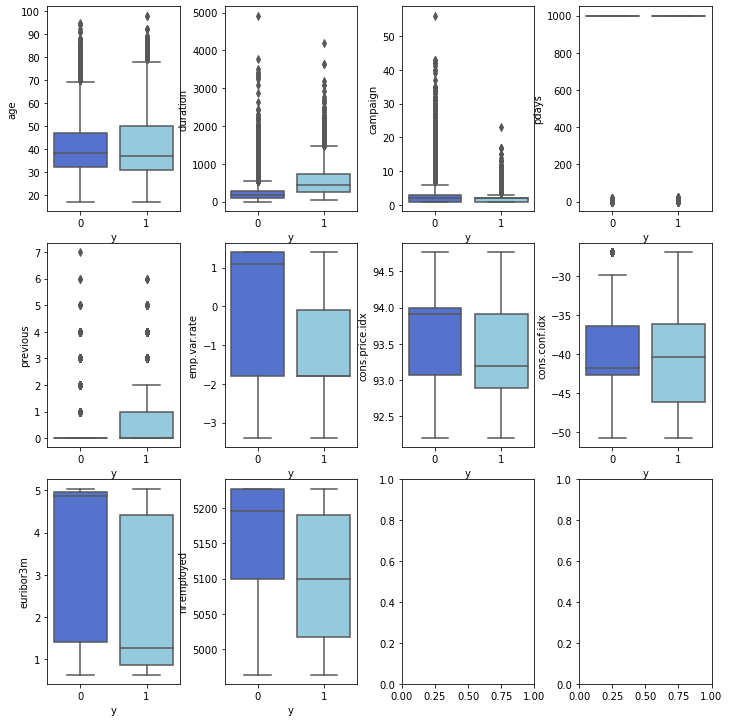

In [40]:
#plot out boxplots for all continuous variables vs. target to identify whether any features
#stand out in terms of difference between subscribed vs. not subscribed

fig, ax = plt.subplots(3, 4, figsize=(10, 10))
fig.tight_layout()
palette_color = {0: "royalblue", 1: "skyblue"}
for feature, subplot in zip(continuous_bank_df.drop('y', axis=1).columns, ax.flatten()):
    sns.boxplot(x = continuous_bank_df['y'], y = continuous_bank_df[feature],ax = subplot, palette = palette_color);



Duration and previous both have high correlation to target variable. Note that the duration variable highly affects the output target. This attribute highly affects the output target (e.g., if duration=0 then y=’no’). Yet, the duration is not known before a call is performed. Also, after the end of the call, the target variable y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

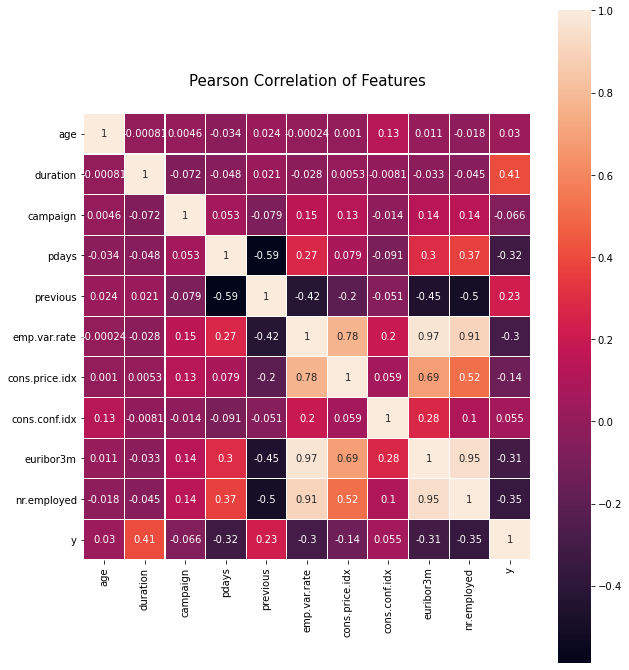

In [41]:
#plot heatmap of correlation matrix of continous varialbes to identify whether there's any collinearity
%matplotlib inline
corr = bank_df.corr()

fig, ax = plt.subplots(figsize=(10,12))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(corr, square=True, ax=ax, annot=True, linewidth=0.1)

plt.title("Pearson Correlation of Features", y=1.05, size=15);

We then plot out the distribution plot of all continuous features below for exploratory purposes. 

Age is exhibiting a right skew distribution, as the 50 percentile is at the age of 38. However, the client dataset also contains a lot of older clients as well. Perhaps targeting an older or younger demographic may be a way to optimize the telemarketing campaign. 

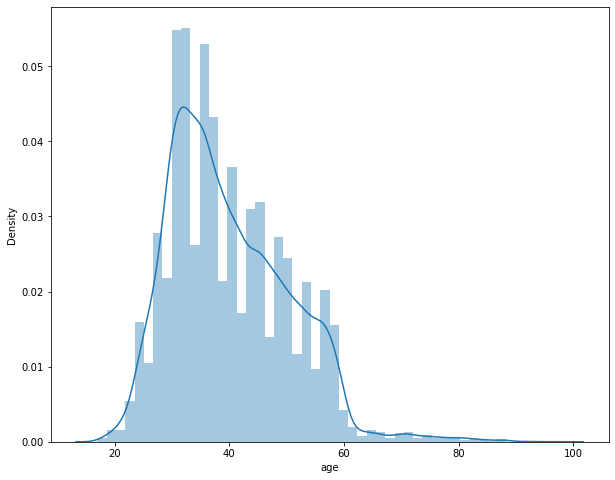

In [42]:
distplot_continuous(bank_df["age"])

In [43]:
bank_df['age'].describe()

count    41176.00000
mean        40.02380
std         10.42068
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64

On average, 258 seconds or around 4-5 minutes is the most common length of each telemarketing call. If duration is an important feature, then it may be best to keep the call to less than 4-5 minutes. We notice that the 50 percentile is at 3 minutes, thus that could be a target to limit the call duration to as the bank may work to reduce the average from 4 - 5 minutes down to the medium range of 3 minutes.  

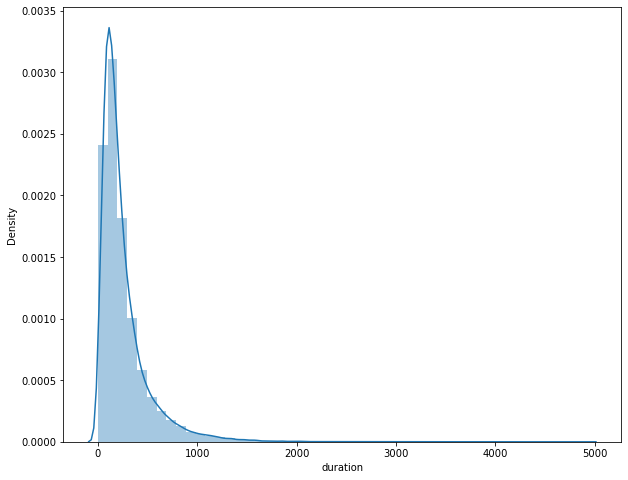

In [44]:
distplot_continuous(bank_df["duration"])

In [45]:
bank_df['duration'].describe()

count    41176.000000
mean       258.315815
std        259.305321
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

We notice that majority of the clients were contacted twice regarding the telemarketing campaign. It would be interesting to see whether this could be reduced to one call. 

In [46]:
bank_df['campaign'].describe()

count    41176.000000
mean         2.567879
std          2.770318
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64

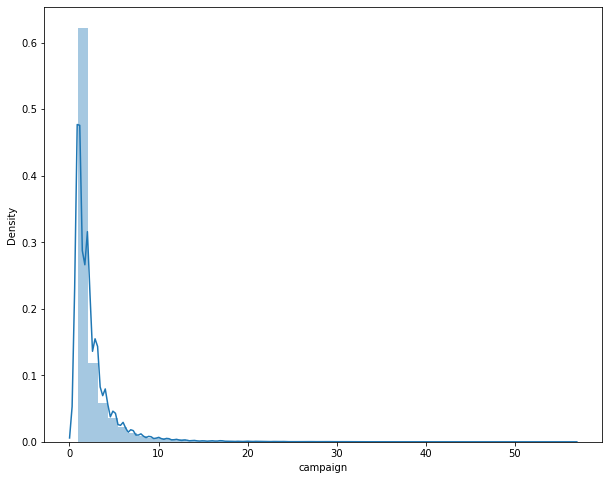

In [47]:
distplot_continuous(bank_df["campaign"])

For 'pdays', it looks like although it is a continuous feature, most values fall either as '999' or the number of previous days that has passed by after the client was last contacted from a previous campaign. Thus it is worth changing pdays to a categorical variable in terms of whether a client was contacted or not. 

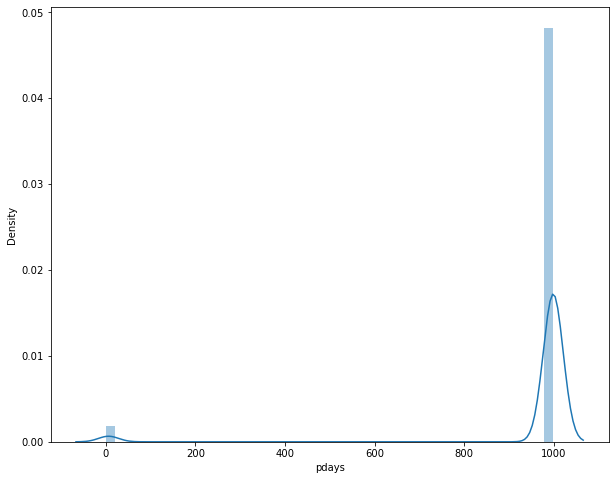

In [48]:
distplot_continuous(bank_df["pdays"])

It looks like most clients were reached out to for the very first time, suggesting that the bank's initiative was to target new customers.  

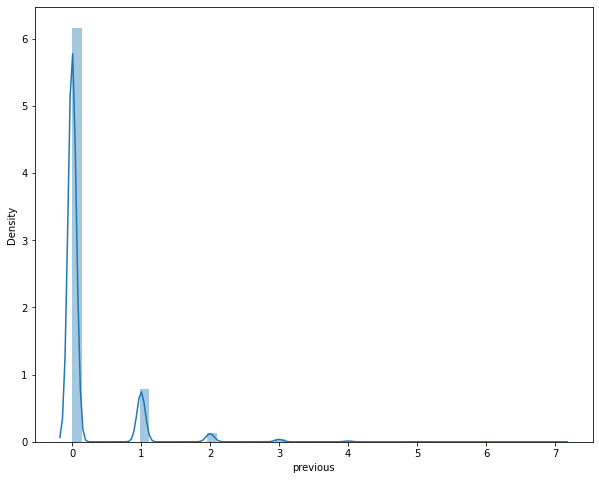

In [49]:
distplot_continuous(bank_df["previous"])

It looks like the bank telemarketing campaign was deployed when the employment variation rate was positive, suggesting that the economy was in an expansionary state. Perhaps this expansion led to the bank's intention to accumulate more clients. 

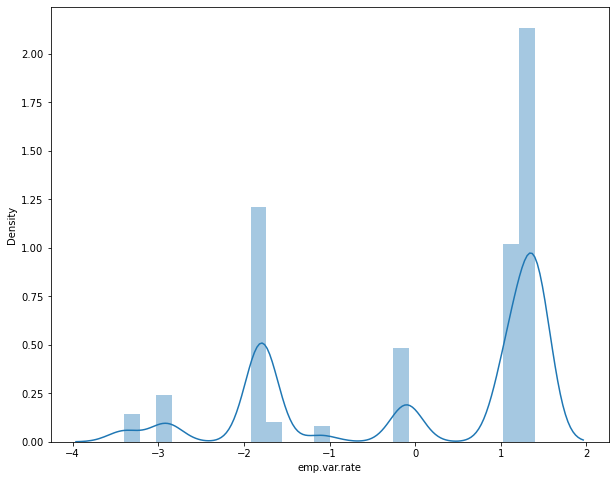

In [50]:
distplot_continuous(bank_df["emp.var.rate"])

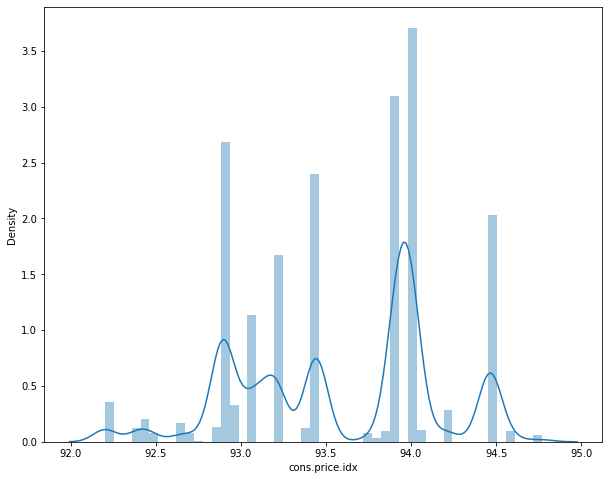

In [51]:
distplot_continuous(bank_df["cons.price.idx"])

A negative consumer confidence index implies that household's have a grim view on future economic situations, suggesting that people are more inclined to save rather than spend. It may be fruitful to look into whether the telemarketing campaigns should be deployed when household's have a more pessimistic outlook of the economy. 

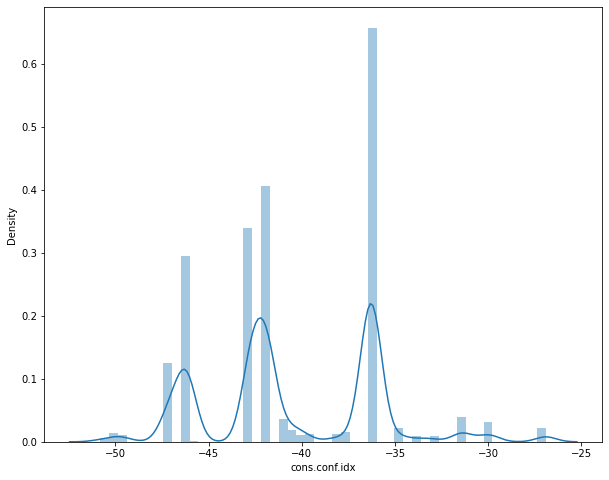

In [52]:
distplot_continuous(bank_df["cons.conf.idx"])

As shown below, the Portuguese bank deployed the telemarketing campaign when the 3-month European interest rates were high, hoping to draw more clients with higher term deposit rates. 

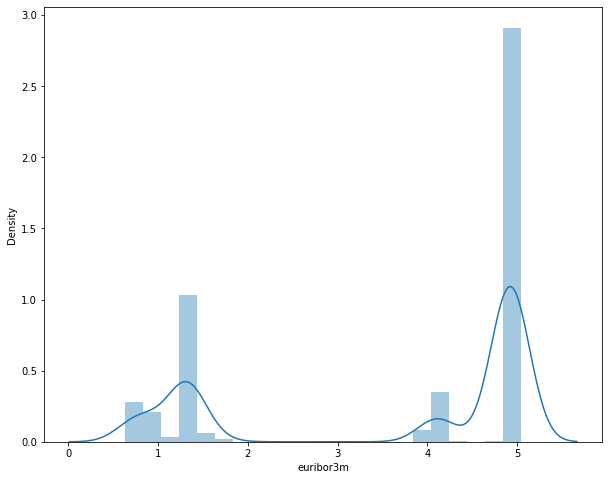

In [53]:
distplot_continuous(bank_df["euribor3m"])

The data below seems to show that as the bank has more employees, the bank is more inclined to perform telemarketing campagins. However, this could also be a sign that the general economy is doing well. 

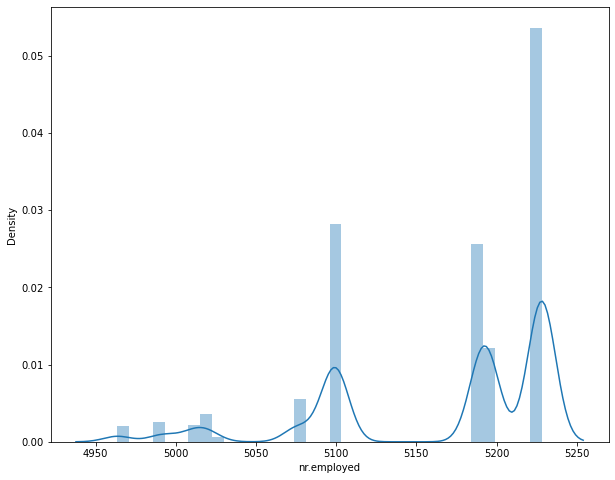

In [54]:
distplot_continuous(bank_df["nr.employed"])

# Data Preprocessing

In [55]:
bank_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

Convert pdays from continuous to categorical, as most values are 999

In [56]:
#convert pdays from numeric to categorical
bank_df['pdays'] = ([0 if each == 999 else 1 for each in bank_df['pdays']])
bank_df['pdays']

0        0
1        0
2        0
3        0
4        0
        ..
41183    0
41184    0
41185    0
41186    0
41187    0
Name: pdays, Length: 41176, dtype: int64

In [57]:
#create a variable that holds all continous variables for later processing. Notice that we removed 'pdays'. 
continuous = ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

#create a variable that holds all categorical variables for later processing, this time adding pdays from continuous to categorical
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'pdays']

Separating Independent and Target Variables 

In [58]:
#dropping target variable out of predictors
X = bank_df.drop('y', axis = 1)

#setting target with y 
y = bank_df['y']

Train Test Split

In [59]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [60]:
#checking for shape sizing of split data 
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (32940, 20)
X_test: (8236, 20)
y_train: (32940,)
y_test: (8236,)


Encoding Categorical Features and Scaling Continuous Features

In [61]:
print(categorical)
print()
print(continuous)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'pdays']

['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [62]:
bank_df_categorical = X_train[categorical]
bank_df_continuous = X_train[continuous]

In [63]:
X_categorical = bank_df_categorical.columns
X_continouous = bank_df_continuous.columns

Creating a Pipeline for further preprocessing

In [64]:
#create a pipeline to normalize via standard scaler our continuous variables and one hot encode our categorical variables

Continous_transform = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

Categorical_transform = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse = False))])
                          
    

pp = ColumnTransformer(transformers=[
    ('continous', Continous_transform, X_continouous),
    ('categorical', Categorical_transform, X_categorical)
    ])

In [65]:
#transform pipeline and convert back into dataframe

X_train_scaled = pp.fit_transform(X_train)
X_test_scaled = pp.transform(X_test)

In [66]:
#aggregating dataframes of categorical and continous variables into one dataframe

categorical_names = pp.transformers_[1][1].named_steps['ohe'].get_feature_names(X_categorical).tolist()
feature_names = list(X_continouous) + categorical_names

X_train_scaled = pd.DataFrame(X_train_scaled, columns = feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = feature_names)

# Dummy Classification Model

In [67]:
#create a dummy model for baseline analysis 
dummy_model = DummyClassifier(strategy = "most_frequent", random_state = 42)

#fit the model on training
dummy_model.fit(X_train, y_train)

# score the model on training
dummy_model.score(X_train, y_train)

# score the model on testing
dummy_model.score(X_test, y_test)

#store as variable for future model comparison 
baseline_model_scoring = dummy_model.score(X_test, y_test)

baseline_model_scoring

0.8821029626032054

We see that the dummy model and the class imbalance reveal very similar scores as the dummy model is predicting on the majority class of 'no', which is around 88.73%

In [68]:
print(f" Dummy Classification Model Score: {dummy_model.score(X_test, y_test)}")
print()
print(f" Class Imbalance: {bank_df['y'].value_counts(normalize=True)}")

 Dummy Classification Model Score: 0.8821029626032054

 Class Imbalance: 0    0.887337
1    0.112663
Name: y, dtype: float64


# Model 1 - Logistic Regression Model 

As a traditional measurement of model performance, accuracy is primarily used as a metric to guage how well a model is doing. However, due to the class imbalance, we will not be using accuracy as our common measurement of model performance as the models will tend to fit the majority class better. Instead, we will use ROC (Receiver Operating Characteristic) and AUC (Area Under Curve) as our performance measurement. 

As an alternative metric to accuracy, AUC provides a more appropriate understanding of how well our model is doing, with ROC graphs providing us with a deeper view into our optimal precision-recall tradeoff balances as the ROC curve depicts the true positive rate against the false positive rate of our classification models. While an AUC of 0.5 or 50% is no better than randomly guessing, we aim to achieve an AUC of between 0.5 and 1.0 across our models. We want our models to be able to distinguish clearly between the subscribed and unsubscribed class. 

The first model we will utilize is the Logistic Regression Model, in which we obtained an AUC score of 0.80 on the training data and 0.79 on the validation data. However, we know that there is a class imbalance in our dataset due to most clients not having a term deposit, thus we will subsequently utilize a balanced class weight in our logistic regression model to see if our model improves. 

In [69]:
#instantiate logistic regression model
logistic_model = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear', random_state = 42)

#fit the model on train
logistic_model.fit(X_train_scaled, y_train)

#predict on train
logistic_model_preds_train = logistic_model.predict(X_train_scaled)

#predict on test 
logistic_model_preds_test = logistic_model.predict(X_test_scaled)

#store AUC score as variable for future model comparisons
logreg_scoring = roc_auc_score(logistic_model_preds_test, y_test)

print(f" AUC Train Score: {roc_auc_score(logistic_model_preds_train, y_train)}")
print('Classification Report on Training Data', "\n")
print(classification_report(y_train, logistic_model_preds_train))

print(f" AUC Test Score: {roc_auc_score(logistic_model_preds_test, y_test)}")
print('Classification Report on Test Data', "\n")
print(classification_report(y_test, logistic_model_preds_test))

 AUC Train Score: 0.800891958099386
Classification Report on Training Data 

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     29272
           1       0.67      0.43      0.52      3668

    accuracy                           0.91     32940
   macro avg       0.80      0.70      0.74     32940
weighted avg       0.90      0.91      0.90     32940

 AUC Test Score: 0.7951471440558948
Classification Report on Test Data 

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7265
           1       0.67      0.41      0.51       971

    accuracy                           0.91      8236
   macro avg       0.80      0.69      0.73      8236
weighted avg       0.89      0.91      0.90      8236



Our confusion matrix reveals a 0.90 accuracy score for our model, which is slightly higher than our baseline model of guessing the majority class. 

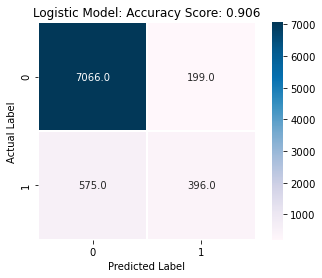

In [70]:
score = round(accuracy_score(y_test, logistic_model_preds_test),3) 
confusion_matrix = cm(y_test, logistic_model_preds_test)
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = 'PuBu')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Logistic Model: Accuracy Score: {0}'.format(score), size = 12)
plt.show()
print("\n")

AUC: 0.7951471440558948


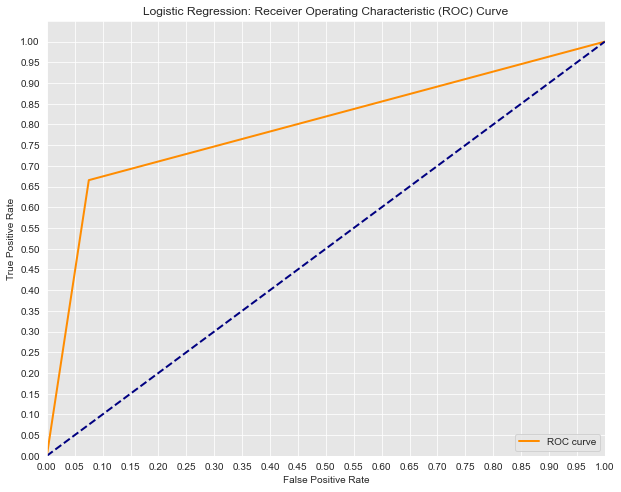

In [71]:
#plot ROC Curve
fpr, tpr, thresholds = roc_curve(logistic_model_preds_test, y_test)

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression: Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Model 2 - Logistic Regression (class weight = balanced) Model

After iterating through our logistic regression model, we will now try to add class_weight as balanced to our new logistic regression model. 

In our balanced class weight model, we obtained an AUC score of 0.714 on the training data and 0.711 on the validation data. Unsurprisingly, our model's predictiability went down after our dataset has been balanced out.

In [72]:
#instantiate logistic regression model with class_weight as balanced, which 
#weights each class inversely proportional to their respective frequencies, giving our "yes" class heavier weights
logistic_model_balanced = LogisticRegression(fit_intercept = False, C = 1e12, class_weight = 'balanced', solver = 'liblinear', random_state = 42)

#fit the model
logistic_model_balanced.fit(X_train_scaled, y_train)

#predict on train
logistic_model_balanced_preds_train = logistic_model_balanced.predict(X_train_scaled)

#predict on test 
logistic_model_balanced_preds_test = logistic_model_balanced.predict(X_test_scaled)

#store as variable for further model comparison
logreg_balanced_scoring = roc_auc_score(logistic_model_balanced_preds_test, y_test)

print(f" AUC Train Score: {roc_auc_score(logistic_model_balanced_preds_train, y_train)}")
print('Classification Report on Training Data', "\n")
print(classification_report(y_train, logistic_model_balanced_preds_train))

print(f" AUC Test Score: {roc_auc_score(logistic_model_balanced_preds_test, y_test)}")
print('Classification Report on Test Data', "\n")
print(classification_report(y_test, logistic_model_balanced_preds_test))


 AUC Train Score: 0.7141883434368458
Classification Report on Training Data 

              precision    recall  f1-score   support

           0       0.98      0.86      0.92     29272
           1       0.44      0.89      0.59      3668

    accuracy                           0.86     32940
   macro avg       0.71      0.88      0.76     32940
weighted avg       0.92      0.86      0.88     32940

 AUC Test Score: 0.7111064221366485
Classification Report on Test Data 

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7265
           1       0.44      0.87      0.59       971

    accuracy                           0.86      8236
   macro avg       0.71      0.86      0.75      8236
weighted avg       0.92      0.86      0.87      8236



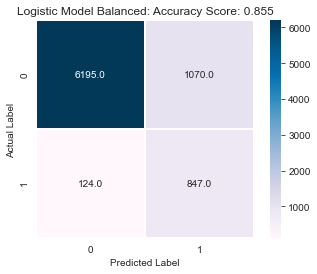

In [73]:
score = round(accuracy_score(y_test, logistic_model_balanced_preds_test),3) 
confusion_matrix = cm(y_test, logistic_model_balanced_preds_test)
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = 'PuBu')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Logistic Model Balanced: Accuracy Score: {0}'.format(score), size = 12)
plt.show()
print("\n")

# Model 3 - Decision Tree Model

We see that our Decision Tree Model's AUC Score improves greatly when compared to the weighted logistic regression model, with an AUC score of 0.802 and 0.801 for training and testing data. We were also able to begin pick up on the model's feature importances, with the top 3 feature importance being duration, nr.employed, and cons.confidence.index. Let's see if these three feature importance remains the top three for other models. 

In [74]:
#instantiate decision tree model
decision_tree_model = DecisionTreeClassifier()

In [75]:
#initiate grid 
decision_tree_param_grid = {'criterion':['gini', 'entropy'],
                            'max_depth':np.arange(1, 15, 2),
                            'min_samples_split':np.arange(5, 100, 5),
                            'min_samples_leaf':np.arange(5,120,5)
                            }
                           

In [76]:
# initiate grid search with 3 fold cross validation
decision_tree_grid_search = GridSearchCV(estimator = decision_tree_model, 
                                        param_grid = decision_tree_param_grid,
                                        scoring = 'roc_auc',
                                        cv = 3,
                                        n_jobs = -1)

In [77]:
#fit model on train
decision_tree_grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  3,  5,  7,  9, 11, 13]),
                         'min_samples_leaf': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115]),
                         'min_samples_split': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])},
             scoring='roc_auc')

In [78]:
#identify best parameters
decision_tree_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 105,
 'min_samples_split': 10}

In [79]:
#predict on train
decision_tree_preds_train = decision_tree_grid_search.predict(X_train_scaled)

#predict on test
decision_tree_preds_test = decision_tree_grid_search.predict(X_test_scaled)

#store as variable for future model comparison
decision_tree_scoring = roc_auc_score(decision_tree_preds_test, y_test)

print(f" AUC score: {roc_auc_score(decision_tree_preds_train, y_train)}")
print('Classification Report on Training Data', "\n")
print(classification_report(y_train, decision_tree_preds_train))

print(f" AUC score: {roc_auc_score(decision_tree_preds_test, y_test)}")
print('Classification Report on Test Data', "\n")
print(classification_report(y_test, decision_tree_preds_test))

 AUC score: 0.8023409592611811
Classification Report on Training Data 

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     29272
           1       0.66      0.53      0.59      3668

    accuracy                           0.92     32940
   macro avg       0.80      0.75      0.77     32940
weighted avg       0.91      0.92      0.91     32940

 AUC score: 0.8015478564678761
Classification Report on Test Data 

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7265
           1       0.67      0.50      0.57       971

    accuracy                           0.91      8236
   macro avg       0.80      0.73      0.76      8236
weighted avg       0.90      0.91      0.91      8236



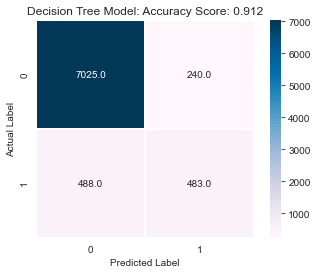

In [80]:
score = round(accuracy_score(y_test, decision_tree_preds_test),3) 
confusion_matrix = cm(y_test, decision_tree_preds_test)
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = 'PuBu')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Decision Tree Model: Accuracy Score: {0}'.format(score), size = 12)
plt.show()
print("\n")

AUC: 0.8015478564678761


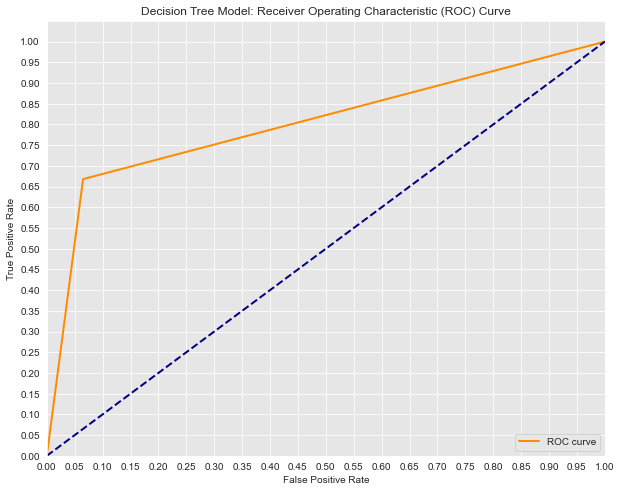

In [81]:
#plot ROC Curve
fpr, tpr, thresholds = roc_curve(decision_tree_preds_test, y_test)

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Model: Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [82]:
#re-run model to generate feature importances
best_params_decision_tree = DecisionTreeClassifier(criterion = 'entropy',
                                                   max_depth = 9, 
                                                   min_samples_leaf = 105,
                                                   min_samples_split = 40)
                                       
best_params_decision_tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=105,
                       min_samples_split=40)

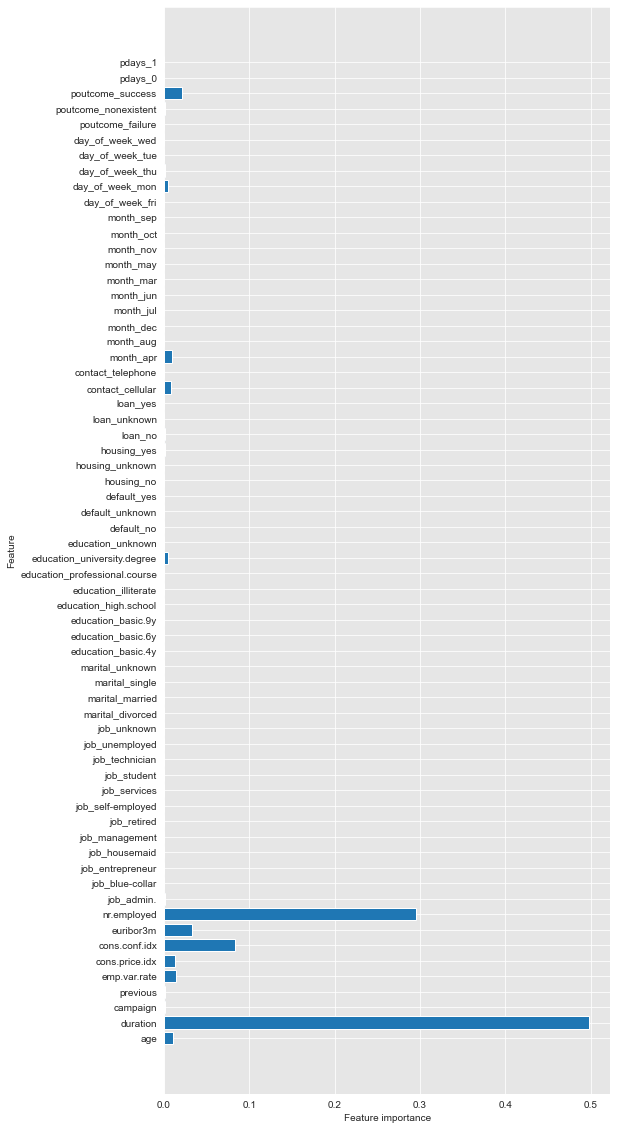

In [83]:
#top feature importances are duration, nr.employed, and cons.confidence.index
plot_feature_importances(best_params_decision_tree)

# Model 4 - Random Forest Classifier Model

We see that our Random Forest Model's AUC Score improves greatly when compared to the previous model, with an AUC score of 0.91 and 0.81 for training and testing data. However, the disparity between the AUC scores also suggests that this model may be overfitting on the data. We were also able to begin pick up on the model's feature importances, with the top 3 feature importance this time around being duration, euribor3m, and nr.employed.

In [84]:
#instantiate random forest classifier
random_forest_model = RandomForestClassifier()

In [85]:
#initiate grid search parameters
random_forest_param_grid = {'n_estimators': [20, 40, 60],
                            'criterion':['gini', 'entropy'],
                            'max_depth':[None, 2, 4],
                            'min_samples_split':[10, 20],
                            'min_samples_leaf':[5, 10, 15]
                           }

In [86]:
# initiate grid search with 3 fold cross validation
random_forest_grid_search = GridSearchCV(estimator = random_forest_model, 
                                        param_grid = random_forest_param_grid,
                                        scoring = 'roc_auc',
                                        cv = 3,
                                        n_jobs = -1)

In [87]:
#fit on train
random_forest_grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 4],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [10, 20],
                         'n_estimators': [20, 40, 60]},
             scoring='roc_auc')

In [88]:
#identify best parameters
random_forest_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'n_estimators': 60}

In [89]:
#predict on train
random_forest_preds_train = random_forest_grid_search.predict(X_train_scaled)

#predict on test
random_forest_preds_test = random_forest_grid_search.predict(X_test_scaled)

#store as variable for future model comparison
random_forest_scoring = roc_auc_score(random_forest_preds_test, y_test)

print(f" AUC score: {roc_auc_score(random_forest_preds_train, y_train)}")
print('Classification Report on Training Data', "\n")
print(classification_report(y_train, random_forest_preds_train))

print(f" AUC score: {roc_auc_score(random_forest_preds_test, y_test)}")
print('Classification Report on Test Data', "\n")
print(classification_report(y_test, random_forest_preds_test))

 AUC score: 0.8995682505703131
Classification Report on Training Data 

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     29272
           1       0.85      0.53      0.66      3668

    accuracy                           0.94     32940
   macro avg       0.90      0.76      0.81     32940
weighted avg       0.93      0.94      0.93     32940

 AUC score: 0.8127012316395233
Classification Report on Test Data 

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7265
           1       0.70      0.37      0.48       971

    accuracy                           0.91      8236
   macro avg       0.81      0.67      0.72      8236
weighted avg       0.90      0.91      0.89      8236



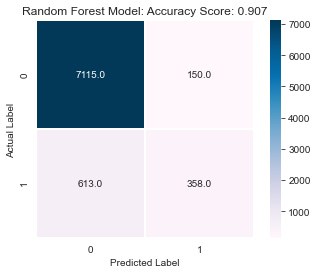

In [90]:
score = round(accuracy_score(y_test, random_forest_preds_test),3) 
confusion_matrix = cm(y_test, random_forest_preds_test)
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = 'PuBu')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Random Forest Model: Accuracy Score: {0}'.format(score), size = 12)
plt.show()
print("\n")

AUC: 0.8127012316395233


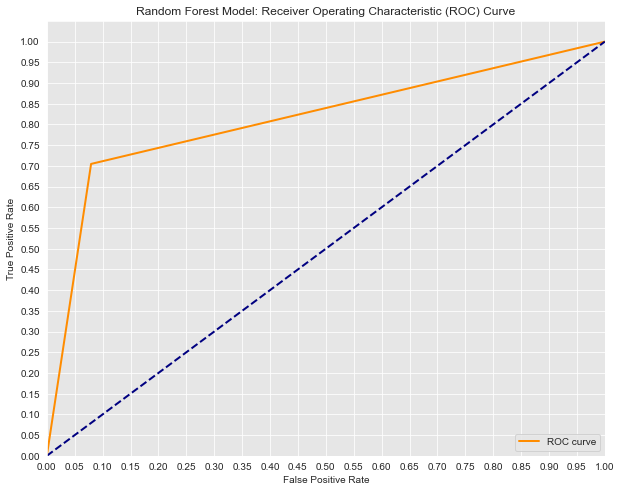

In [91]:
#plot ROC Curve 

fpr, tpr, thresholds = roc_curve(random_forest_preds_test, y_test)

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Model: Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [92]:
#re-run model to generate feature importances
best_params_random_forest = RandomForestClassifier(criterion = 'entropy',
                                       max_depth = None, 
                                       min_samples_leaf = 10,
                                       min_samples_split = 10,
                                       n_estimators = 60,
                                      )
                                                                          
best_params_random_forest.fit(X_train_scaled, y_train)


RandomForestClassifier(criterion='entropy', min_samples_leaf=10,
                       min_samples_split=10, n_estimators=60)

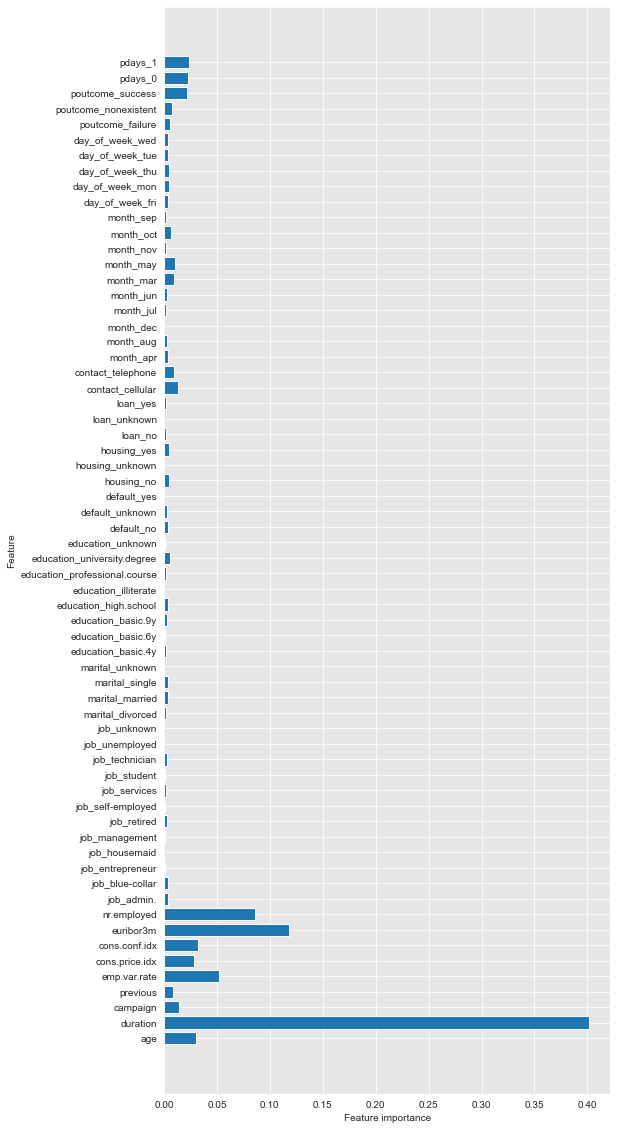

In [93]:
#top feature importances are duration, euribor3m, and nr.employed
plot_feature_importances(best_params_random_forest)

# Model 5 - K-Nearest Neighbors Algorithm Model

We see that our Random Forest Model's AUC Score produces an AUC score of 1.0 and a test AUC score of 0.79, suggesting that the model is severly overfitting to the training data. 

In [94]:
#instantiate model
knn_model = KNeighborsClassifier()

In [95]:
#initiate grid search parameters
knn_param_grid = {'n_neighbors': list(range(1, 20, 2)),
                  'weights':['uniform', 'distance'],
                  'leaf_size':[20, 30],
                  }
                            

In [96]:
# initiate grid search with 3 fold cross validation
knn_grid_search = GridSearchCV(estimator = knn_model, 
                               param_grid = knn_param_grid,
                               scoring = 'roc_auc',
                               cv = 3,
                               n_jobs = -1)

In [97]:
#fit on train
knn_grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': [20, 30],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [98]:
#identify best parameters 
knn_grid_search.best_params_

{'leaf_size': 20, 'n_neighbors': 19, 'weights': 'distance'}

In [99]:
#predict on train
knn_preds_train = knn_grid_search.predict(X_train_scaled)

#predict on test
knn_preds_test = knn_grid_search.predict(X_test_scaled)

#store as variable for future model comparison
knn_scoring = roc_auc_score(knn_preds_test, y_test)

print(f" AUC score: {roc_auc_score(knn_preds_train, y_train)}")
print('Classification Report on Training Data', "\n")
print(classification_report(y_train, knn_preds_train))

print(f" AUC score: {roc_auc_score(knn_preds_test, y_test)}")
print('Classification Report on Test Data', "\n")
print(classification_report(y_test, knn_preds_test))

 AUC score: 1.0
Classification Report on Training Data 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29272
           1       1.00      1.00      1.00      3668

    accuracy                           1.00     32940
   macro avg       1.00      1.00      1.00     32940
weighted avg       1.00      1.00      1.00     32940

 AUC score: 0.7908160120535561
Classification Report on Test Data 

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7265
           1       0.66      0.37      0.48       971

    accuracy                           0.90      8236
   macro avg       0.79      0.67      0.71      8236
weighted avg       0.89      0.90      0.89      8236



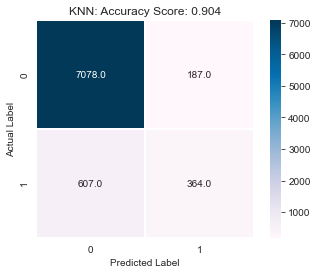

In [100]:
score = round(accuracy_score(y_test, knn_preds_test),3) 
confusion_matrix = cm(y_test, knn_preds_test)
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = 'PuBu')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('KNN: Accuracy Score: {0}'.format(score), size = 12)
plt.show()
print("\n")

AUC: 0.7908160120535561


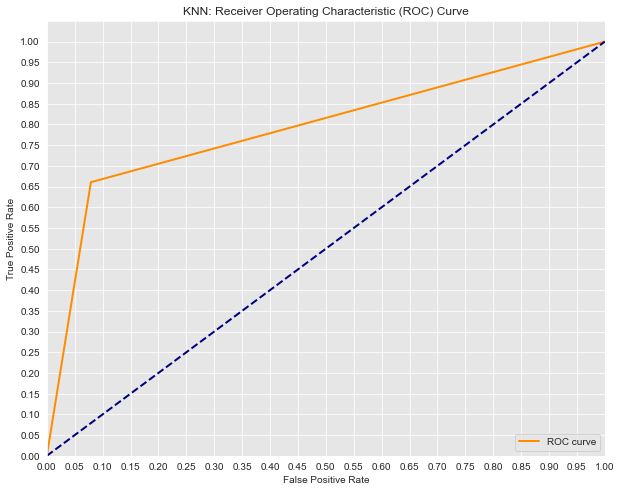

In [101]:
#plot ROC Curve 

fpr, tpr, thresholds = roc_curve(knn_preds_test, y_test)

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN: Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Model 6 - Gradient Boosting Model

We see that the Gradient Boostin Model's AUC Score improves greatly to 0.825 and 0.801 respectively for training and test data. We were also able to pick up on the model's feature importances, with the top 3 feature importance being duration, nr.employed, and euribor3m. It seems like these three features continue to be one of the more important features across the board.  

In [102]:
#instantiate model
gradient_boost_model = GradientBoostingClassifier()

In [103]:
# initiate parameter grid
gradient_boost_param_grid = {'loss': ['deviance', 'exponential'],
                             'learning_rate':[0.1, 0.2, 0.3],
                             'n_estimators':[100, 110, 120]}
                            
                            

In [104]:
# initiate grid search with 3 fold cross validation
gradient_boost_grid_search = GridSearchCV(estimator = gradient_boost_model, 
                                        param_grid = gradient_boost_param_grid,
                                        scoring = 'roc_auc',
                                        cv = 3,
                                        n_jobs = -1)

In [105]:
#fit on training
gradient_boost_grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'loss': ['deviance', 'exponential'],
                         'n_estimators': [100, 110, 120]},
             scoring='roc_auc')

In [106]:
#identify best parameters
gradient_boost_grid_search.best_params_

{'learning_rate': 0.2, 'loss': 'exponential', 'n_estimators': 120}

In [107]:
#predict on train
gradient_boost_preds_train = gradient_boost_grid_search.predict(X_train_scaled)

#predict on test
gradient_boost_preds_test = gradient_boost_grid_search.predict(X_test_scaled)

#store as variable for futher model comparison  
gradient_boost_scoring = roc_auc_score(gradient_boost_preds_test, y_test)

print(f" AUC score: {roc_auc_score(gradient_boost_preds_train, y_train)}")
print('Classification Report on Training Data', "\n")
print(classification_report(y_train, gradient_boost_preds_train))

print(f" AUC score: {roc_auc_score(gradient_boost_preds_test, y_test)}")
print('Classification Report on Test Data', "\n")
print(classification_report(y_test, gradient_boost_preds_test))

 AUC score: 0.8254399464703914
Classification Report on Training Data 

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     29272
           1       0.70      0.58      0.64      3668

    accuracy                           0.93     32940
   macro avg       0.83      0.78      0.80     32940
weighted avg       0.92      0.93      0.92     32940

 AUC score: 0.8014677299849308
Classification Report on Test Data 

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7265
           1       0.67      0.51      0.58       971

    accuracy                           0.91      8236
   macro avg       0.80      0.74      0.76      8236
weighted avg       0.90      0.91      0.91      8236



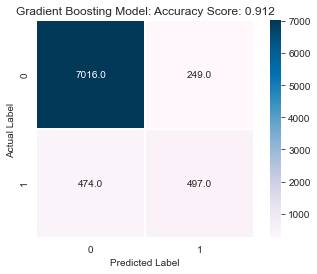

In [108]:
score = round(accuracy_score(y_test, gradient_boost_preds_test),3) 
confusion_matrix = cm(y_test, gradient_boost_preds_test)
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = 'PuBu')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Gradient Boosting Model: Accuracy Score: {0}'.format(score), size = 12)
plt.show()
print("\n")

AUC: 0.8014677299849308


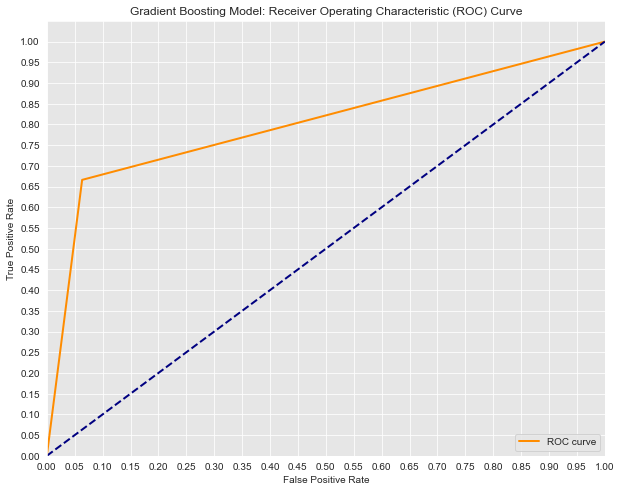

In [109]:
#plot ROC Curve 
fpr, tpr, thresholds = roc_curve(gradient_boost_preds_test, y_test)

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting Model: Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [110]:
#re-run model to generate feature importances
best_params_gradient_boost = GradientBoostingClassifier(learning_rate = 0.3,
                                                        loss = 'deviance',
                                                        n_estimators = 110)
                                      
best_params_gradient_boost.fit(X_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.3, n_estimators=110)

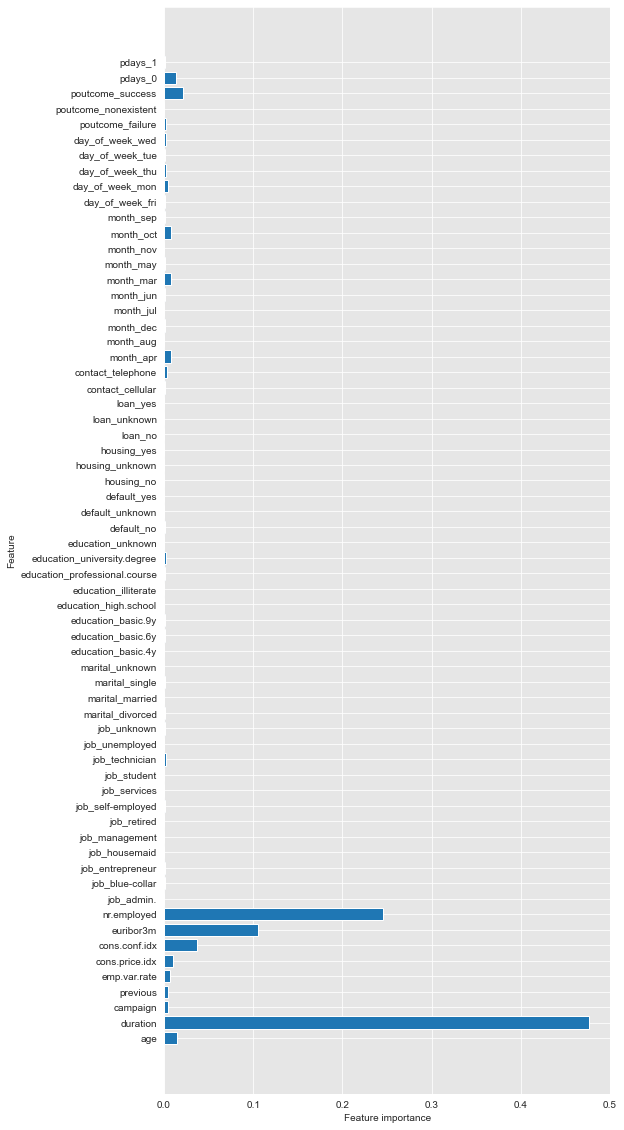

In [111]:
#top 3 feature importances: duration, nr.employed, and euribor3m
plot_feature_importances(best_params_gradient_boost)

# Model 7 - XG Boost

We see that the XG Boost Model's AUC Score is 0.872 and 0.810 respectively for training and test data. Similar to other models, we were also able to pick up on the model's feature importances, with the top 3 feature importance being
nr.emoployed, duration, and pdays_0. 

In [112]:
# instantiate model
xg_boost_model = XGBClassifier()

In [113]:
# initiate parameter grid 
xg_boost_param_grid = {'learning_rate': [0.1, 0.2],
                       'max_depth':[6],
                       'min_child_weight':[1,2],
                       'subsample':[0.5,0.7],
                       'n_estimators':[100],
                      }              

In [114]:
# initiate grid search with 3 fold cross validation
xg_boost_grid_search = GridSearchCV(estimator = xg_boost_model, 
                                        param_grid = xg_boost_param_grid,
                                        scoring = 'roc_auc',
                                        cv = 3,
                                        n_jobs = -1)

In [115]:
#fit on training
xg_boost_grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [116]:
#identify best parameters
xg_boost_grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 0.7}

In [117]:
#predict on train
xg_boost_preds_train = xg_boost_grid_search.predict(X_train_scaled)

#predict on test
xg_boost_preds_test = xg_boost_grid_search.predict(X_test_scaled)

#store as variable for future model comparison
xg_boost_scoring = roc_auc_score(xg_boost_preds_test, y_test)

print(f" AUC score: {roc_auc_score(xg_boost_preds_train, y_train)}")
print('Classification Report on Training Data', "\n")
print(classification_report(y_train, xg_boost_preds_train))

print(f" AUC score: {roc_auc_score(xg_boost_preds_test, y_test)}")
print('Classification Report on Test Data', "\n")
print(classification_report(y_test, xg_boost_preds_test))

 AUC score: 0.8720487050293653
Classification Report on Training Data 

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     29272
           1       0.79      0.65      0.71      3668

    accuracy                           0.94     32940
   macro avg       0.87      0.81      0.84     32940
weighted avg       0.94      0.94      0.94     32940

 AUC score: 0.8104005173093203
Classification Report on Test Data 

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7265
           1       0.68      0.53      0.60       971

    accuracy                           0.92      8236
   macro avg       0.81      0.75      0.78      8236
weighted avg       0.91      0.92      0.91      8236



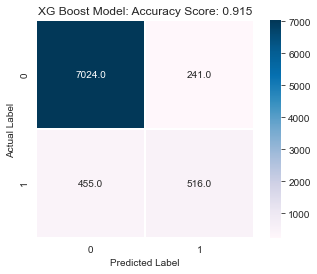

In [118]:
score = round(accuracy_score(y_test, xg_boost_preds_test),3) 
confusion_matrix = cm(y_test, xg_boost_preds_test)
sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = 'PuBu')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('XG Boost Model: Accuracy Score: {0}'.format(score), size = 12)
plt.show()
print("\n")

AUC: 0.8104005173093203


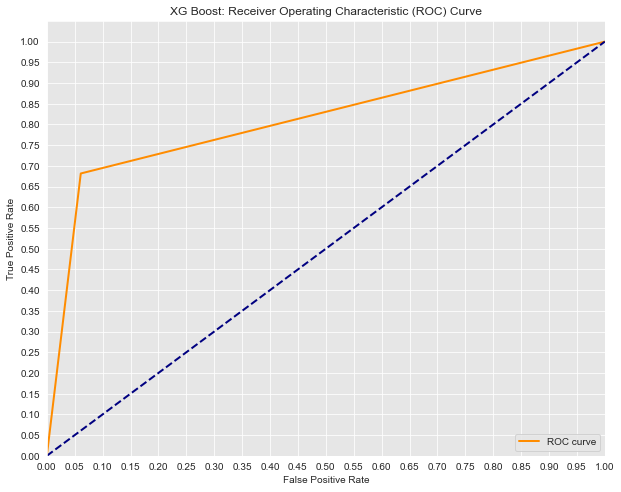

In [119]:
#plot ROC Curve

fpr, tpr, thresholds = roc_curve(xg_boost_preds_test, y_test)

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XG Boost: Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [120]:
#re-run model to generate feature importances
best_params_xg_boost = XGBClassifier(learning_rate = 0.1,
                                       max_depth = 6, 
                                       min_child_weight = 1,
                                       n_estimators = 100,
                                       subsample = 0.7,)
                                     
best_params_xg_boost.fit(X_train_scaled, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

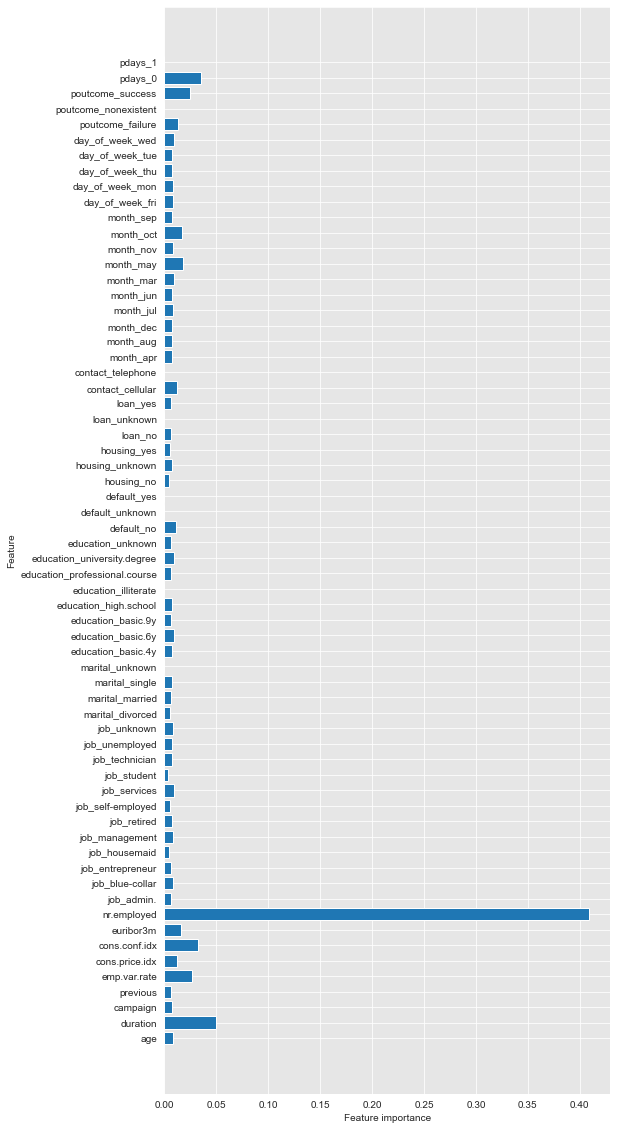

In [121]:
#top 3 feature importances: nr.employed, duration, pdays_0
plot_feature_importances(best_params_xg_boost)

# Model Results

When evaluating across all models deployed for this project, we are able to identify a 0.815 AUC Score for our Random Forest Model, followed by an AUC Score of 0.81 from our XG Boost and an AUC score of 0.802 from our Decision Tree Model. Furthemore, from our top performing model, we were able to identify our top 3 features that we can utilize as a way to further recommend the bank during its next telemarketing campaign. In conclusion, we would recommend the bank to focus on the duration of each call, the 3-month European interest rate, and pay attention to the number of employees working for the firm. 

With regards to the duration of each call, we saw that on average, 4 to 5 minutes is spent over the phone speaking with the client. However, we could explore reducing the average call time down to the median call time of 3 minutes. 

Secondly, we would like to pay close attention to the 3-month European interest rates and recommend the bank to deploy its telemarketing campaign when interest rates are high. 

Lastly, we would recommend the bank to initiate its telemarketing campaign with the help from as many employees as possible. As the bank expands, so should its customer base. While only the first recommendation pertains to the client-base, the second and third recommendation rely more on macroeconomic and economic factors. Contrary to how one might believe that client-specific data may have driven the sucess of obtaining more term deposit subscriptions, macroeconomic and economic factors seem to carry more importance. 


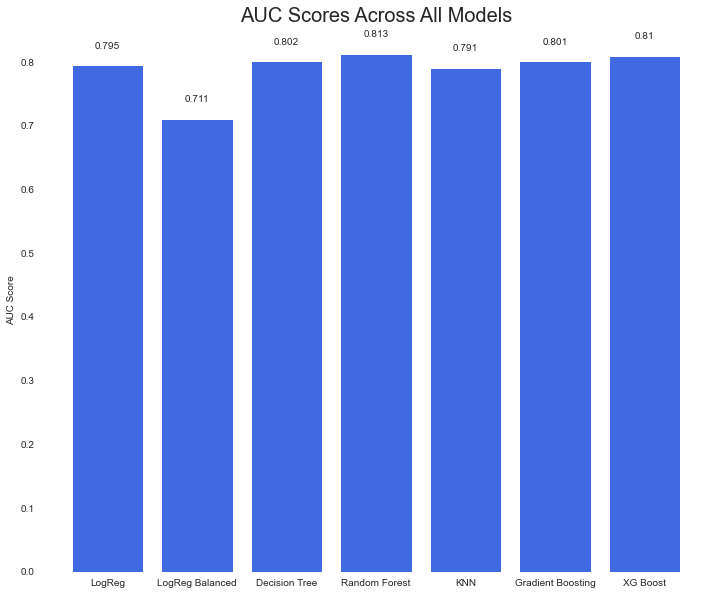

In [122]:
#plot out model results across all models

x_axis = ['LogReg', 'LogReg Balanced', 'Decision Tree', 'Random Forest', 'KNN', 'Gradient Boosting', 'XG Boost']
y_axis = [logreg_scoring, logreg_balanced_scoring, decision_tree_scoring, random_forest_scoring, knn_scoring, gradient_boost_scoring, xg_boost_scoring] 

fig, ax = plt.subplots(figsize = (12, 10))
ax.bar(x_axis, y_axis, color = 'royalblue')
ax.set_title('AUC Scores Across All Models', fontsize = 20)
ax.set_ylabel('AUC Score')
ax.set_facecolor('white')

for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    
    label_text = round(height, 3)
    
    label_x = x + width / 2
    label_y = y + height + 0.03
    ax.text(label_x, label_y, label_text, ha = 'center', va = 'center', fontsize = 10)
plt.grid(False)
plt.show();

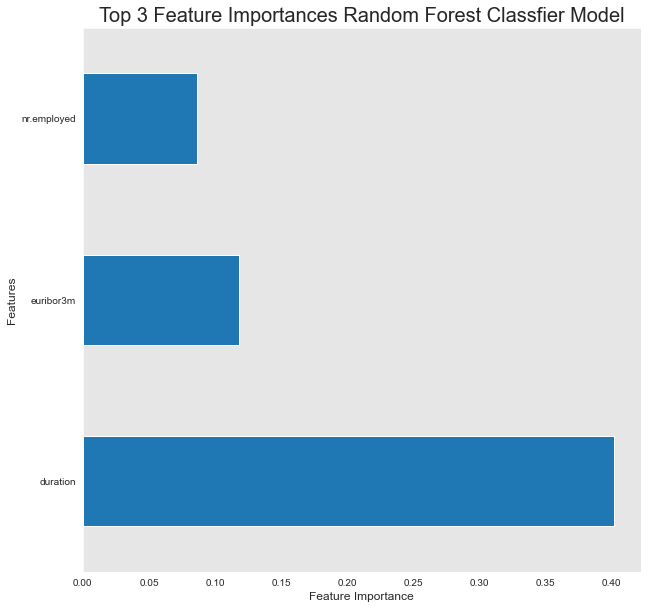

In [153]:
#plot out top 3 features from best model: Random Forest Model
pd.Series(best_params_random_forest.feature_importances_, index = feature_names).nlargest(3).plot(kind='barh', figsize = (10, 10))

plt.title('Top 3 Feature Importances Random Forest Classfier Model', fontsize = 20)
plt.ylabel('Features', fontsize = 12)
plt.xlabel('Feature Importance', fontsize = 12)
plt.grid(False)

plt.plot;